# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2495 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

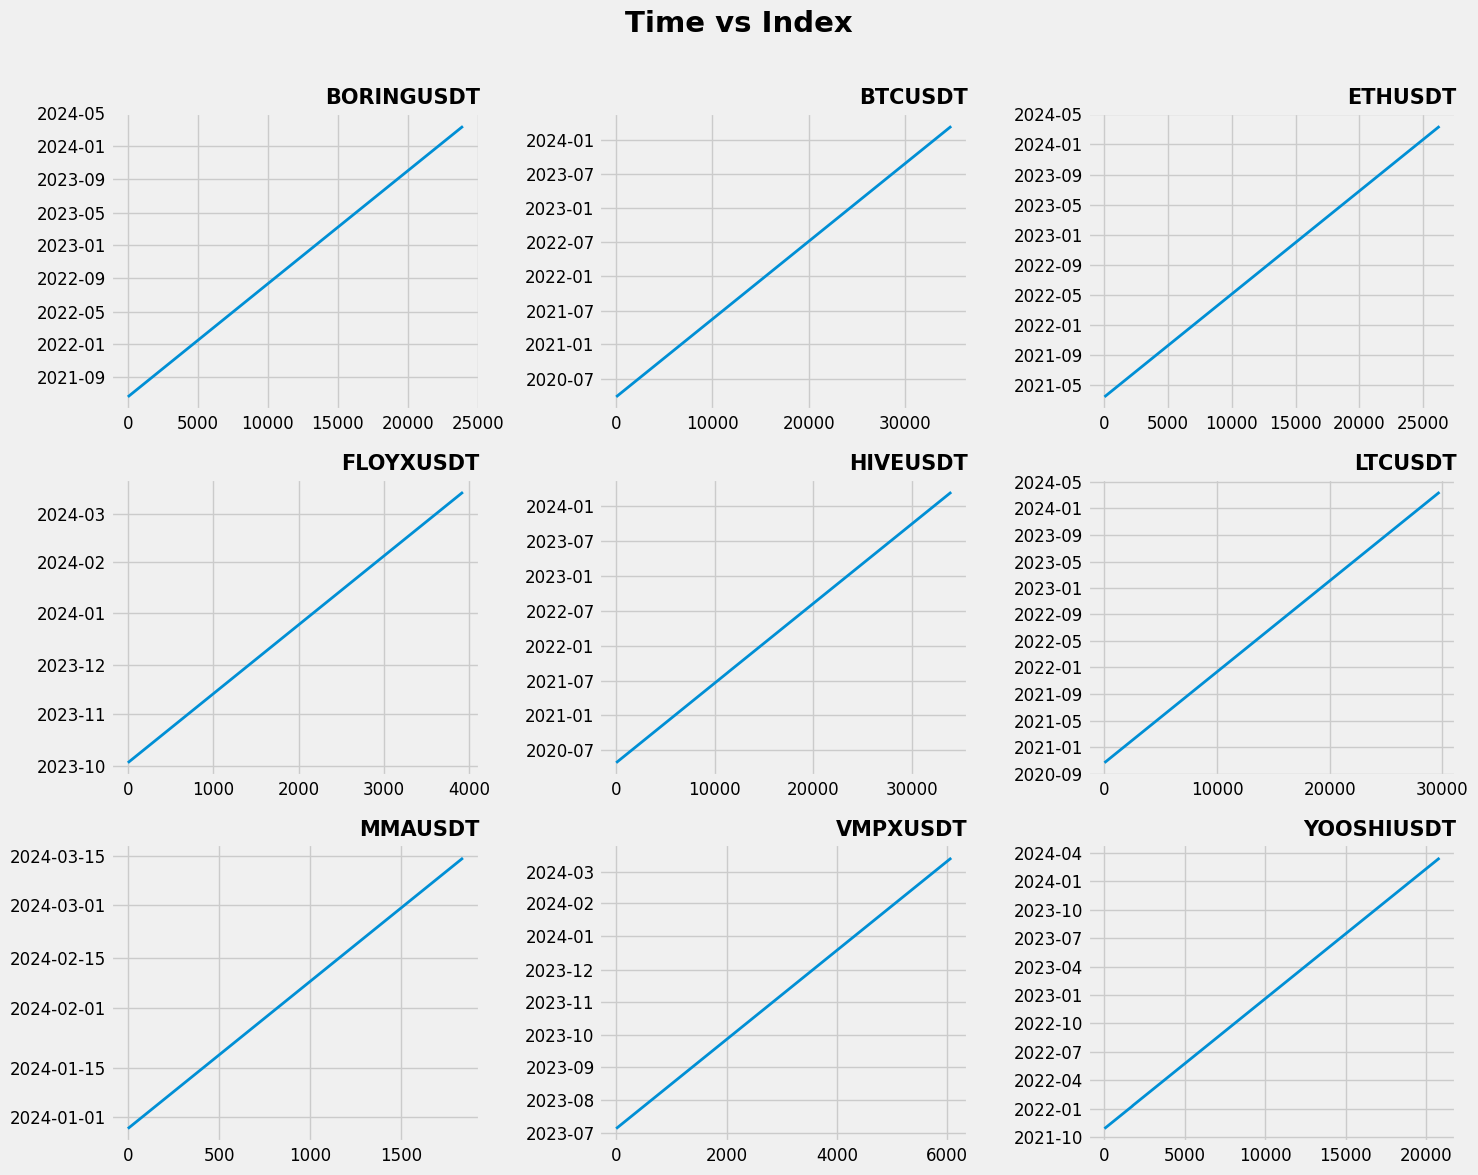

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,702,1256,0.558917,"(0.5316, 0.5862)"
3,1,1,860,1610,0.534161,"(0.5099, 0.5584)"
5,2,1,810,1526,0.530799,"(0.5059, 0.5557)"
7,3,1,935,1794,0.521182,"(0.4982, 0.5442)"
9,16,1,768,1411,0.544295,"(0.5184, 0.5701)"
11,17,1,748,1440,0.519444,"(0.4938, 0.5451)"
13,21,1,804,1481,0.542876,"(0.5176, 0.5681)"
15,22,1,832,1492,0.557641,"(0.5326, 0.5827)"
17,23,1,726,1282,0.566303,"(0.5393, 0.5933)"


buy    13292
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7185
0       STOCH_RSI_Volume24    6107
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.540551
0       STOCH_RSI_Volume24    0.459449
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,485,930,0.521505,"(0.4896, 0.5534)"
3,4,1,766,1437,0.533055,"(0.5074, 0.5587)"
5,14,1,745,1384,0.538295,"(0.5122, 0.5644)"
7,16,1,600,1135,0.528634,"(0.4997, 0.5575)"
9,17,1,532,941,0.565356,"(0.5338, 0.5969)"
11,18,1,474,893,0.530795,"(0.4982, 0.5634)"
13,19,1,489,905,0.540331,"(0.508, 0.5726)"
15,21,1,524,952,0.550420,"(0.519, 0.5819)"
17,22,1,476,895,0.531844,"(0.4993, 0.5644)"
19,23,1,524,943,0.555673,"(0.5241, 0.5872)"


sell    10415
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5615
0       STOCH_RSI_Volume24    4800
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539126
0       STOCH_RSI_Volume24    0.460874
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

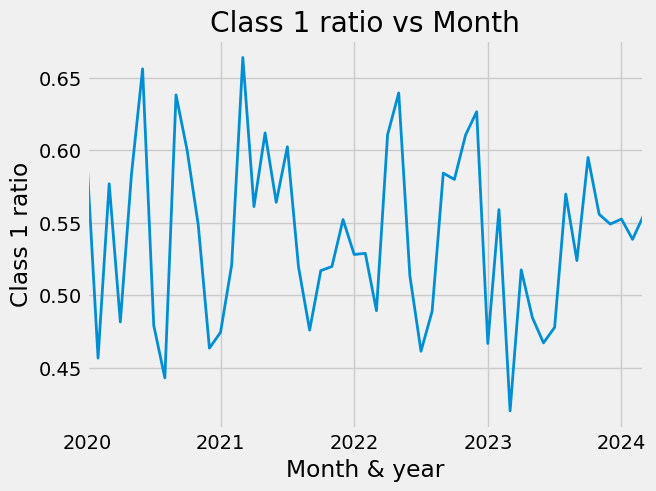

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

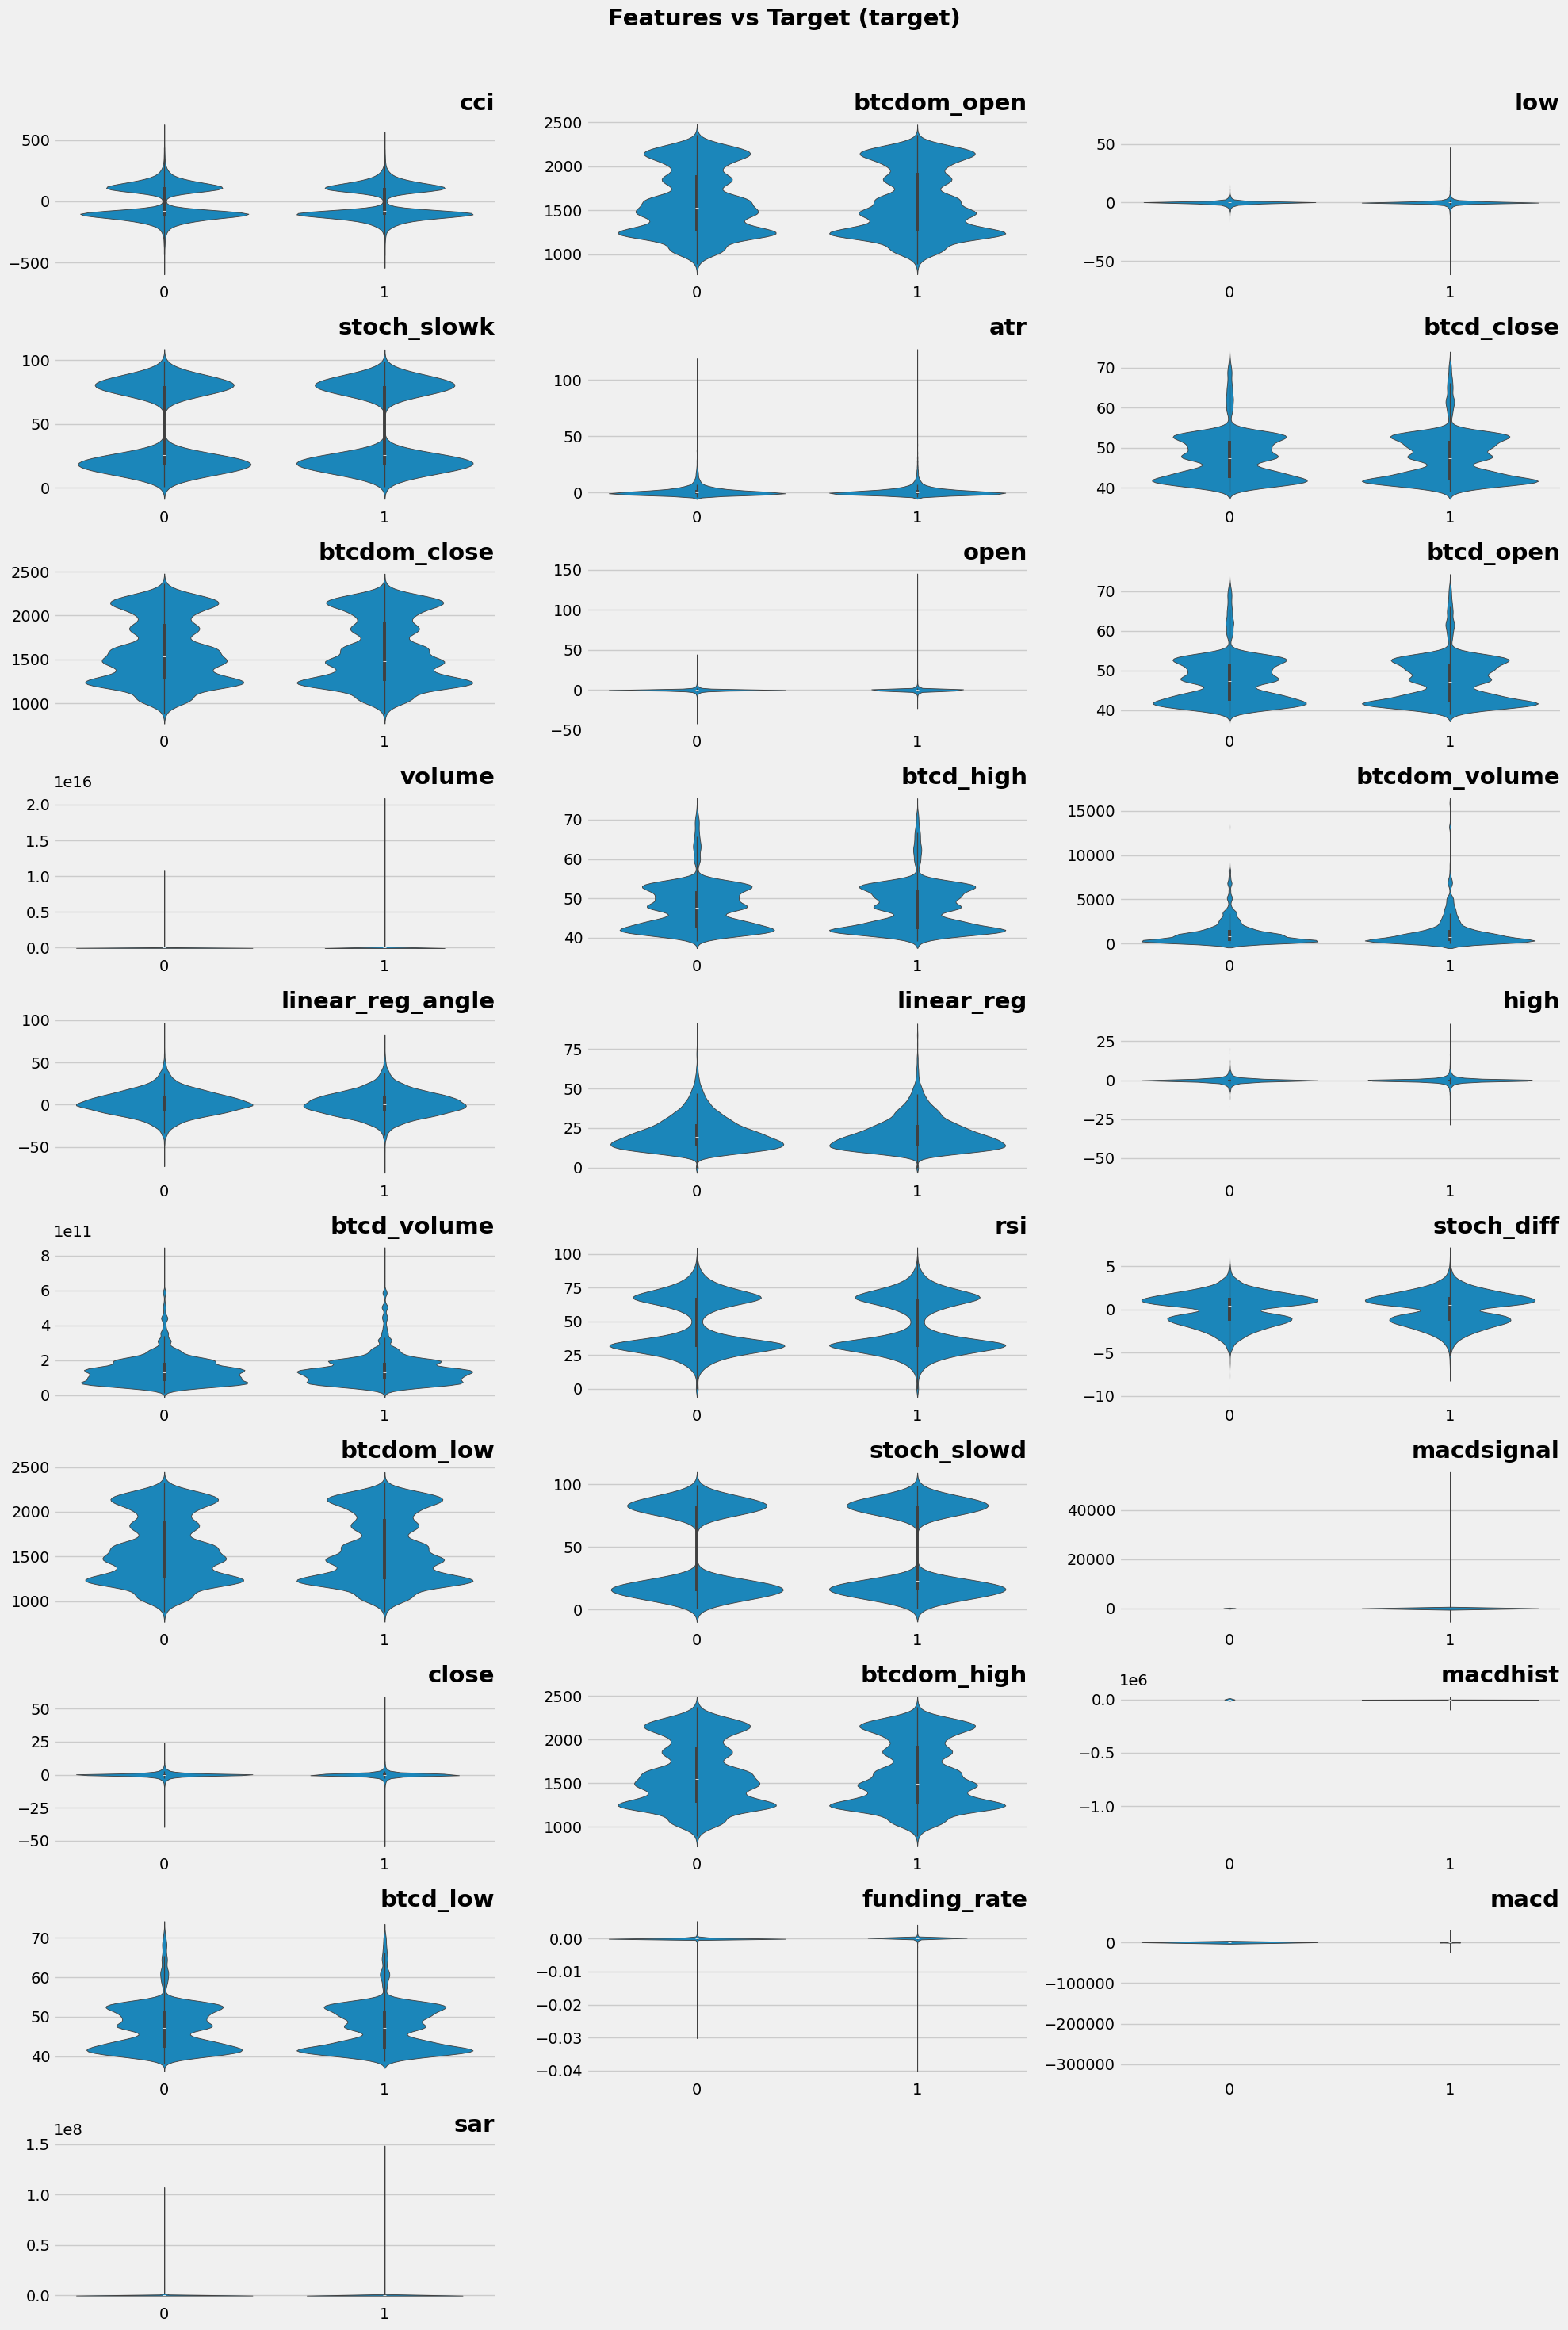

In [17]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
75790,2024-03-14 01:00:00,CTXCUSDT,buy,STOCH_RSI_Volume24
75791,2024-03-14 02:00:00,ROGUSDT,sell,STOCH_RSI_Volume24
75792,2024-03-14 03:00:00,BCUTUSDT,sell,STOCH_RSI_Volume24
75793,2024-03-14 03:00:00,FDUSDUSDT,sell,STOCH_RSI_Volume24
75794,2024-03-14 03:00:00,XWGUSDT,sell,STOCH_RSI_Volume24
75795,2024-03-14 03:00:00,XAVAUSDT,sell,STOCH_RSI_Volume24
75796,2024-03-14 03:00:00,SCPTUSDT,sell,STOCH_RSI_Volume24
75797,2024-03-14 04:00:00,SOLUSDT,sell,STOCH_RSI_Volume24
75798,2024-03-14 04:00:00,JUP_USDT,sell,STOCH_RSI_Volume24
75799,2024-03-14 04:00:00,ERTHAUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']]])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv')
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

### Load selected features

In [23]:
def prepare_features(fi, feature_num):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
feature_num = 132 # 80
features, feature_dict = prepare_features(fi, feature_num)
features = features + ['weekday']
display(features)

['cci',
 'btcdom_open',
 'low',
 'stoch_slowk',
 'atr',
 'btcdom_volume_prev_4',
 'rsi_prev_4',
 'btcdom_high_prev_4',
 'cci_prev_4',
 'stoch_diff_prev_4',
 'btcdom_close_prev_4',
 'btcdom_low_prev_4',
 'btcdom_volume_prev_8',
 'cci_prev_8',
 'stoch_slowd_prev_8',
 'btcdom_volume_prev_12',
 'btcdom_volume_prev_16',
 'stoch_slowk_prev_16',
 'rsi_prev_16',
 'stoch_slowd_prev_16',
 'btcdom_volume_prev_20',
 'high_prev_24',
 'btcdom_volume_prev_24',
 'stoch_diff_prev_24',
 'btcd_low_prev_24',
 'stoch_diff_prev_28',
 'btcdom_volume_prev_32',
 'rsi_prev_32',
 'cci_prev_32',
 'rsi_prev_36',
 'low_prev_36',
 'btcdom_volume_prev_40',
 'low_prev_40',
 'btcdom_volume_prev_44',
 'close_prev_44',
 'stoch_diff_prev_44',
 'cci_prev_44',
 'cci_prev_48',
 'open_prev_48',
 'stoch_slowk_prev_48',
 'btcd_open_prev_48',
 'btcd_volume_prev_48',
 'rsi_prev_52',
 'atr_prev_52',
 'stoch_diff_prev_52',
 'stoch_diff_prev_56',
 'btcdom_volume_prev_56',
 'btcdom_volume_prev_68',
 'stoch_slowk_prev_68',
 'rsi_prev_

# Train

### Fucntion to remove features that correlate with other features too much and are not too important

In [24]:
# corr_thresh = 0.9208549086841545
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude

### Functions for train and optimization

In [25]:
val_idxs = list()
prec_score_list = list()
with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                   
        'verbose': -1,
        'importance_type': 'gain',
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num)
    features = features + ['weekday']

    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('model/optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('model/optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [35]:
params = {
            'boosting_type': 'dart',
            'n_estimators': 2583,
            'learning_rate': 0.0002346215193142581,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.8226162386453161,
            'subsample': 0.40571361458738814,
            'max_depth': 10,
            'num_leaves': 23,
            'max_bin': 51,
            'reg_alpha': 7.2400478513365e-05,
            'reg_lambda': 3.978472026116517e-06,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

# params = {
#             'boosting_type': 'dart',
#             'n_estimators': 2220,
#             'learning_rate': 0.00034720124060409334,
#             'is_unbalance': True,
#             'class_weight': 'balanced',
#             'colsample_bytree': 0.7450341880143819,
#             'subsample': 0.4250562645372095,
#             'max_depth': 10,
#             'num_leaves': 31,
#             'max_bin': 39,
#             'reg_alpha': 0.00045604169506076255,
#             'reg_lambda': 8.844366397798992e-07,
#             'subsample_freq': 1,
#             'objective': 'binary',
#             'importance_type': 'gain',
#             'metric': 'average_precision',
#             'verbosity': -1
#         }

train_test = 'full' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('model/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full': 
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
#     joblib.dump(model, f'model/lgbm.pkl') 
#     # save feature dictionary for further inference
#     with open(f'model/features.json', 'w') as f:
#         json.dump(feature_dict, f)

Train on full data
[100]	training's binary_logloss: 0.692531	training's average_precision: 0.702094
[200]	training's binary_logloss: 0.692168	training's average_precision: 0.70518
[300]	training's binary_logloss: 0.691733	training's average_precision: 0.707331
[400]	training's binary_logloss: 0.691272	training's average_precision: 0.707489
[500]	training's binary_logloss: 0.690781	training's average_precision: 0.708594
[600]	training's binary_logloss: 0.690511	training's average_precision: 0.708304
[700]	training's binary_logloss: 0.690075	training's average_precision: 0.708496
[800]	training's binary_logloss: 0.689747	training's average_precision: 0.708881
[900]	training's binary_logloss: 0.689307	training's average_precision: 0.709566
[1000]	training's binary_logloss: 0.688972	training's average_precision: 0.710063
[1100]	training's binary_logloss: 0.688566	training's average_precision: 0.710624
[1200]	training's binary_logloss: 0.688305	training's average_precision: 0.710925
[1300]	

In [36]:
# Training with 81 features
# Fold #1
# 1    0.540329
# 0    0.459671
# Name: target, dtype: float64Timestamp('2022-07-08 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691329	training's average_precision: 0.786525	valid_1's binary_logloss: 0.69296	valid_1's average_precision: 0.573403
# [200]	training's binary_logloss: 0.690227	training's average_precision: 0.78935	valid_1's binary_logloss: 0.692861	valid_1's average_precision: 0.58294
# [300]	training's binary_logloss: 0.688923	training's average_precision: 0.791283	valid_1's binary_logloss: 0.69278	valid_1's average_precision: 0.575718
# [400]	training's binary_logloss: 0.687584	training's average_precision: 0.793127	valid_1's binary_logloss: 0.692766	valid_1's average_precision: 0.582068
# [500]	training's binary_logloss: 0.686091	training's average_precision: 0.794442	valid_1's binary_logloss: 0.692692	valid_1's average_precision: 0.584348
# [600]	training's binary_logloss: 0.685353	training's average_precision: 0.794751	valid_1's binary_logloss: 0.692637	valid_1's average_precision: 0.58331
# [700]	training's binary_logloss: 0.684109	training's average_precision: 0.795271	valid_1's binary_logloss: 0.69252	valid_1's average_precision: 0.583872
# [800]	training's binary_logloss: 0.683186	training's average_precision: 0.795133	valid_1's binary_logloss: 0.692473	valid_1's average_precision: 0.583366
# [900]	training's binary_logloss: 0.681914	training's average_precision: 0.795756	valid_1's binary_logloss: 0.692382	valid_1's average_precision: 0.58486
# [1000]	training's binary_logloss: 0.680936	training's average_precision: 0.796404	valid_1's binary_logloss: 0.692348	valid_1's average_precision: 0.584231
# [1100]	training's binary_logloss: 0.679787	training's average_precision: 0.796529	valid_1's binary_logloss: 0.692242	valid_1's average_precision: 0.583067
# [1200]	training's binary_logloss: 0.679014	training's average_precision: 0.797044	valid_1's binary_logloss: 0.692194	valid_1's average_precision: 0.585069
# [1300]	training's binary_logloss: 0.678042	training's average_precision: 0.798036	valid_1's binary_logloss: 0.692109	valid_1's average_precision: 0.584344
# [1400]	training's binary_logloss: 0.676699	training's average_precision: 0.798577	valid_1's binary_logloss: 0.692005	valid_1's average_precision: 0.585241
# [1500]	training's binary_logloss: 0.675998	training's average_precision: 0.798727	valid_1's binary_logloss: 0.69195	valid_1's average_precision: 0.58522
# [1600]	training's binary_logloss: 0.674819	training's average_precision: 0.799456	valid_1's binary_logloss: 0.691939	valid_1's average_precision: 0.584594
# [1700]	training's binary_logloss: 0.673557	training's average_precision: 0.799679	valid_1's binary_logloss: 0.691955	valid_1's average_precision: 0.584261
# [1800]	training's binary_logloss: 0.672481	training's average_precision: 0.800303	valid_1's binary_logloss: 0.691889	valid_1's average_precision: 0.584881
# [1900]	training's binary_logloss: 0.671344	training's average_precision: 0.800952	valid_1's binary_logloss: 0.691809	valid_1's average_precision: 0.58437
# [2000]	training's binary_logloss: 0.670411	training's average_precision: 0.801939	valid_1's binary_logloss: 0.691716	valid_1's average_precision: 0.583389
# [2100]	training's binary_logloss: 0.669048	training's average_precision: 0.802641	valid_1's binary_logloss: 0.69169	valid_1's average_precision: 0.583545
# [2200]	training's binary_logloss: 0.667969	training's average_precision: 0.803095	valid_1's binary_logloss: 0.691616	valid_1's average_precision: 0.585825
# Logloss: 0.6916195649787708, Confident objects precision: 0.5771715721464465
# Number of confident objects 4179, % of confident objects: 0.5099450884685784
# Number of profitable objects: 645
# Fold #2
# 1    0.54302
# 0    0.45698
# Name: target, dtype: float64Timestamp('2022-10-01 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691506	training's average_precision: 0.766951	valid_1's binary_logloss: 0.692984	valid_1's average_precision: 0.604307
# [200]	training's binary_logloss: 0.690511	training's average_precision: 0.7692	valid_1's binary_logloss: 0.692869	valid_1's average_precision: 0.597229
# [300]	training's binary_logloss: 0.689322	training's average_precision: 0.76986	valid_1's binary_logloss: 0.692722	valid_1's average_precision: 0.596858
# [400]	training's binary_logloss: 0.688115	training's average_precision: 0.770206	valid_1's binary_logloss: 0.692528	valid_1's average_precision: 0.590784
# [500]	training's binary_logloss: 0.686784	training's average_precision: 0.770988	valid_1's binary_logloss: 0.692466	valid_1's average_precision: 0.59119
# [600]	training's binary_logloss: 0.686118	training's average_precision: 0.771017	valid_1's binary_logloss: 0.692315	valid_1's average_precision: 0.59129
# [700]	training's binary_logloss: 0.68497	training's average_precision: 0.771141	valid_1's binary_logloss: 0.692178	valid_1's average_precision: 0.589213
# [800]	training's binary_logloss: 0.684143	training's average_precision: 0.77219	valid_1's binary_logloss: 0.692102	valid_1's average_precision: 0.586813
# [900]	training's binary_logloss: 0.682974	training's average_precision: 0.773548	valid_1's binary_logloss: 0.692082	valid_1's average_precision: 0.588793
# [1000]	training's binary_logloss: 0.682102	training's average_precision: 0.774424	valid_1's binary_logloss: 0.692012	valid_1's average_precision: 0.591817
# [1100]	training's binary_logloss: 0.681092	training's average_precision: 0.775233	valid_1's binary_logloss: 0.691999	valid_1's average_precision: 0.592953
# [1200]	training's binary_logloss: 0.680422	training's average_precision: 0.775163	valid_1's binary_logloss: 0.691893	valid_1's average_precision: 0.591914
# [1300]	training's binary_logloss: 0.679532	training's average_precision: 0.775761	valid_1's binary_logloss: 0.691863	valid_1's average_precision: 0.590339
# [1400]	training's binary_logloss: 0.678343	training's average_precision: 0.776071	valid_1's binary_logloss: 0.691695	valid_1's average_precision: 0.589406
# [1500]	training's binary_logloss: 0.677704	training's average_precision: 0.776587	valid_1's binary_logloss: 0.69165	valid_1's average_precision: 0.589153
# [1600]	training's binary_logloss: 0.676649	training's average_precision: 0.776647	valid_1's binary_logloss: 0.691526	valid_1's average_precision: 0.590927
# [1700]	training's binary_logloss: 0.675559	training's average_precision: 0.777097	valid_1's binary_logloss: 0.691478	valid_1's average_precision: 0.589772
# [1800]	training's binary_logloss: 0.674604	training's average_precision: 0.777394	valid_1's binary_logloss: 0.691316	valid_1's average_precision: 0.590139
# [1900]	training's binary_logloss: 0.673566	training's average_precision: 0.777916	valid_1's binary_logloss: 0.691174	valid_1's average_precision: 0.591223
# [2000]	training's binary_logloss: 0.672723	training's average_precision: 0.778701	valid_1's binary_logloss: 0.69105	valid_1's average_precision: 0.590133
# [2100]	training's binary_logloss: 0.671484	training's average_precision: 0.778964	valid_1's binary_logloss: 0.691031	valid_1's average_precision: 0.588367
# [2200]	training's binary_logloss: 0.670521	training's average_precision: 0.779225	valid_1's binary_logloss: 0.69096	valid_1's average_precision: 0.587901
# Logloss: 0.6909595953700833, Confident objects precision: 0.5639921722113503
# Number of confident objects 5110, % of confident objects: 0.7125923859991633
# Number of profitable objects: 654
# Fold #3
# 1    0.536744
# 0    0.463256
# Name: target, dtype: float64Timestamp('2023-01-29 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691611	training's average_precision: 0.762029	valid_1's binary_logloss: 0.693089	valid_1's average_precision: 0.560186
# [200]	training's binary_logloss: 0.690696	training's average_precision: 0.761136	valid_1's binary_logloss: 0.693014	valid_1's average_precision: 0.561815
# [300]	training's binary_logloss: 0.689589	training's average_precision: 0.763135	valid_1's binary_logloss: 0.692956	valid_1's average_precision: 0.564792
# [400]	training's binary_logloss: 0.68849	training's average_precision: 0.763721	valid_1's binary_logloss: 0.6929	valid_1's average_precision: 0.567083
# [500]	training's binary_logloss: 0.687252	training's average_precision: 0.76448	valid_1's binary_logloss: 0.692804	valid_1's average_precision: 0.562802
# [600]	training's binary_logloss: 0.686632	training's average_precision: 0.764816	valid_1's binary_logloss: 0.692758	valid_1's average_precision: 0.56741
# [700]	training's binary_logloss: 0.685587	training's average_precision: 0.765937	valid_1's binary_logloss: 0.692677	valid_1's average_precision: 0.568228
# [800]	training's binary_logloss: 0.684807	training's average_precision: 0.767012	valid_1's binary_logloss: 0.692613	valid_1's average_precision: 0.567272
# [900]	training's binary_logloss: 0.683726	training's average_precision: 0.767741	valid_1's binary_logloss: 0.692619	valid_1's average_precision: 0.566569
# [1000]	training's binary_logloss: 0.682897	training's average_precision: 0.768513	valid_1's binary_logloss: 0.692598	valid_1's average_precision: 0.568823
# [1100]	training's binary_logloss: 0.681935	training's average_precision: 0.76913	valid_1's binary_logloss: 0.692602	valid_1's average_precision: 0.56702
# [1200]	training's binary_logloss: 0.681314	training's average_precision: 0.769456	valid_1's binary_logloss: 0.692652	valid_1's average_precision: 0.568403
# [1300]	training's binary_logloss: 0.680494	training's average_precision: 0.77021	valid_1's binary_logloss: 0.692583	valid_1's average_precision: 0.567876
# [1400]	training's binary_logloss: 0.679373	training's average_precision: 0.770843	valid_1's binary_logloss: 0.692511	valid_1's average_precision: 0.567767
# [1500]	training's binary_logloss: 0.678785	training's average_precision: 0.771317	valid_1's binary_logloss: 0.692529	valid_1's average_precision: 0.571098
# [1600]	training's binary_logloss: 0.677775	training's average_precision: 0.771986	valid_1's binary_logloss: 0.692481	valid_1's average_precision: 0.570625
# [1700]	training's binary_logloss: 0.676725	training's average_precision: 0.772311	valid_1's binary_logloss: 0.692424	valid_1's average_precision: 0.571098
# [1800]	training's binary_logloss: 0.675845	training's average_precision: 0.772655	valid_1's binary_logloss: 0.692349	valid_1's average_precision: 0.569134
# [1900]	training's binary_logloss: 0.674888	training's average_precision: 0.77296	valid_1's binary_logloss: 0.692268	valid_1's average_precision: 0.567944
# [2000]	training's binary_logloss: 0.67411	training's average_precision: 0.773369	valid_1's binary_logloss: 0.692277	valid_1's average_precision: 0.568821
# [2100]	training's binary_logloss: 0.67297	training's average_precision: 0.773702	valid_1's binary_logloss: 0.692248	valid_1's average_precision: 0.568749
# [2200]	training's binary_logloss: 0.67207	training's average_precision: 0.774511	valid_1's binary_logloss: 0.692188	valid_1's average_precision: 0.569028
# Logloss: 0.6922356860646338, Confident objects precision: 0.570267830273849
# Number of confident objects 3323, % of confident objects: 0.5414697735049698
# Number of profitable objects: 467
# Fold #4
# 1    0.544039
# 0    0.455961
# Name: target, dtype: float64Timestamp('2023-04-20 21:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691721	training's average_precision: 0.755153	valid_1's binary_logloss: 0.693102	valid_1's average_precision: 0.59215
# [200]	training's binary_logloss: 0.690873	training's average_precision: 0.755682	valid_1's binary_logloss: 0.693057	valid_1's average_precision: 0.597491
# [300]	training's binary_logloss: 0.689851	training's average_precision: 0.758159	valid_1's binary_logloss: 0.693122	valid_1's average_precision: 0.585538
# [400]	training's binary_logloss: 0.688802	training's average_precision: 0.758772	valid_1's binary_logloss: 0.693091	valid_1's average_precision: 0.595441
# [500]	training's binary_logloss: 0.687636	training's average_precision: 0.76115	valid_1's binary_logloss: 0.693171	valid_1's average_precision: 0.591399
# [600]	training's binary_logloss: 0.687053	training's average_precision: 0.760024	valid_1's binary_logloss: 0.693178	valid_1's average_precision: 0.594369
# [700]	training's binary_logloss: 0.686061	training's average_precision: 0.760726	valid_1's binary_logloss: 0.693117	valid_1's average_precision: 0.594055
# [800]	training's binary_logloss: 0.685347	training's average_precision: 0.761272	valid_1's binary_logloss: 0.693105	valid_1's average_precision: 0.594288
# [900]	training's binary_logloss: 0.68435	training's average_precision: 0.76262	valid_1's binary_logloss: 0.692979	valid_1's average_precision: 0.598237
# [1000]	training's binary_logloss: 0.683592	training's average_precision: 0.763213	valid_1's binary_logloss: 0.692943	valid_1's average_precision: 0.598973
# [1100]	training's binary_logloss: 0.682688	training's average_precision: 0.763581	valid_1's binary_logloss: 0.692895	valid_1's average_precision: 0.60298
# [1200]	training's binary_logloss: 0.682094	training's average_precision: 0.7641	valid_1's binary_logloss: 0.692873	valid_1's average_precision: 0.604487
# [1300]	training's binary_logloss: 0.681322	training's average_precision: 0.764573	valid_1's binary_logloss: 0.692883	valid_1's average_precision: 0.603141
# [1400]	training's binary_logloss: 0.68027	training's average_precision: 0.765231	valid_1's binary_logloss: 0.692879	valid_1's average_precision: 0.60227
# [1500]	training's binary_logloss: 0.679704	training's average_precision: 0.765805	valid_1's binary_logloss: 0.69287	valid_1's average_precision: 0.604221
# [1600]	training's binary_logloss: 0.678782	training's average_precision: 0.766295	valid_1's binary_logloss: 0.692897	valid_1's average_precision: 0.603763
# [1700]	training's binary_logloss: 0.677813	training's average_precision: 0.766663	valid_1's binary_logloss: 0.692921	valid_1's average_precision: 0.60249
# [1800]	training's binary_logloss: 0.676973	training's average_precision: 0.766988	valid_1's binary_logloss: 0.692898	valid_1's average_precision: 0.601681
# [1900]	training's binary_logloss: 0.676091	training's average_precision: 0.767492	valid_1's binary_logloss: 0.692931	valid_1's average_precision: 0.600862
# [2000]	training's binary_logloss: 0.675335	training's average_precision: 0.76788	valid_1's binary_logloss: 0.692919	valid_1's average_precision: 0.600541
# [2100]	training's binary_logloss: 0.67424	training's average_precision: 0.767979	valid_1's binary_logloss: 0.692929	valid_1's average_precision: 0.599944
# [2200]	training's binary_logloss: 0.673394	training's average_precision: 0.768591	valid_1's binary_logloss: 0.692948	valid_1's average_precision: 0.599077
# Logloss: 0.6929546888009354, Confident objects precision: 0.6202686202686203
# Number of confident objects 819, % of confident objects: 0.16775911511675543
# Number of profitable objects: 197
# Fold #5
# 1    0.565531
# 0    0.434469
# Name: target, dtype: float64Timestamp('2023-06-24 01:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691752	training's average_precision: 0.752588	valid_1's binary_logloss: 0.693464	valid_1's average_precision: 0.590045
# [200]	training's binary_logloss: 0.69089	training's average_precision: 0.751556	valid_1's binary_logloss: 0.693669	valid_1's average_precision: 0.588117
# [300]	training's binary_logloss: 0.689889	training's average_precision: 0.754568	valid_1's binary_logloss: 0.693932	valid_1's average_precision: 0.582216
# [400]	training's binary_logloss: 0.68884	training's average_precision: 0.754995	valid_1's binary_logloss: 0.694238	valid_1's average_precision: 0.580685
# [500]	training's binary_logloss: 0.687711	training's average_precision: 0.756894	valid_1's binary_logloss: 0.69447	valid_1's average_precision: 0.579167
# [600]	training's binary_logloss: 0.687132	training's average_precision: 0.756549	valid_1's binary_logloss: 0.694571	valid_1's average_precision: 0.581863
# [700]	training's binary_logloss: 0.686166	training's average_precision: 0.757014	valid_1's binary_logloss: 0.694797	valid_1's average_precision: 0.58423
# [800]	training's binary_logloss: 0.685442	training's average_precision: 0.757674	valid_1's binary_logloss: 0.694881	valid_1's average_precision: 0.585983
# [900]	training's binary_logloss: 0.684443	training's average_precision: 0.758384	valid_1's binary_logloss: 0.695162	valid_1's average_precision: 0.585396
# [1000]	training's binary_logloss: 0.683688	training's average_precision: 0.758764	valid_1's binary_logloss: 0.695291	valid_1's average_precision: 0.584749
# [1100]	training's binary_logloss: 0.682786	training's average_precision: 0.759506	valid_1's binary_logloss: 0.695418	valid_1's average_precision: 0.587665
# [1200]	training's binary_logloss: 0.682202	training's average_precision: 0.759913	valid_1's binary_logloss: 0.695573	valid_1's average_precision: 0.588027
# [1300]	training's binary_logloss: 0.681453	training's average_precision: 0.760349	valid_1's binary_logloss: 0.695746	valid_1's average_precision: 0.585961
# [1400]	training's binary_logloss: 0.68041	training's average_precision: 0.760854	valid_1's binary_logloss: 0.696058	valid_1's average_precision: 0.58429
# [1500]	training's binary_logloss: 0.679872	training's average_precision: 0.761149	valid_1's binary_logloss: 0.696161	valid_1's average_precision: 0.584368
# [1600]	training's binary_logloss: 0.678969	training's average_precision: 0.762064	valid_1's binary_logloss: 0.69642	valid_1's average_precision: 0.585102
# [1700]	training's binary_logloss: 0.678009	training's average_precision: 0.7625	valid_1's binary_logloss: 0.696746	valid_1's average_precision: 0.584648
# [1800]	training's binary_logloss: 0.677186	training's average_precision: 0.762934	valid_1's binary_logloss: 0.696962	valid_1's average_precision: 0.585648
# [1900]	training's binary_logloss: 0.676311	training's average_precision: 0.763194	valid_1's binary_logloss: 0.697291	valid_1's average_precision: 0.584454
# [2000]	training's binary_logloss: 0.675603	training's average_precision: 0.763522	valid_1's binary_logloss: 0.697512	valid_1's average_precision: 0.585048
# [2100]	training's binary_logloss: 0.674562	training's average_precision: 0.764074	valid_1's binary_logloss: 0.697857	valid_1's average_precision: 0.584023
# [2200]	training's binary_logloss: 0.67373	training's average_precision: 0.764568	valid_1's binary_logloss: 0.698157	valid_1's average_precision: 0.583355
# Logloss: 0.6981878418505787, Confident objects precision: 0.7642276422764228
# Number of confident objects 123, % of confident objects: 0.03173374613003096
# Number of profitable objects: 65
# Fold #6
# 1    0.577911
# 0    0.422089
# Name: target, dtype: float64Timestamp('2023-09-12 14:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.691879	training's average_precision: 0.743387	valid_1's binary_logloss: 0.693273	valid_1's average_precision: 0.595184
# [200]	training's binary_logloss: 0.691113	training's average_precision: 0.746412	valid_1's binary_logloss: 0.693279	valid_1's average_precision: 0.612156
# [300]	training's binary_logloss: 0.690225	training's average_precision: 0.748045	valid_1's binary_logloss: 0.69338	valid_1's average_precision: 0.605745
# [400]	training's binary_logloss: 0.689283	training's average_precision: 0.747556	valid_1's binary_logloss: 0.693464	valid_1's average_precision: 0.603471
# [500]	training's binary_logloss: 0.688262	training's average_precision: 0.749807	valid_1's binary_logloss: 0.693475	valid_1's average_precision: 0.608355
# [600]	training's binary_logloss: 0.687756	training's average_precision: 0.749883	valid_1's binary_logloss: 0.693497	valid_1's average_precision: 0.613124
# [700]	training's binary_logloss: 0.686878	training's average_precision: 0.749779	valid_1's binary_logloss: 0.693571	valid_1's average_precision: 0.611583
# [800]	training's binary_logloss: 0.686215	training's average_precision: 0.750146	valid_1's binary_logloss: 0.693566	valid_1's average_precision: 0.61505
# [900]	training's binary_logloss: 0.685325	training's average_precision: 0.751024	valid_1's binary_logloss: 0.693613	valid_1's average_precision: 0.617803
# [1000]	training's binary_logloss: 0.684646	training's average_precision: 0.751233	valid_1's binary_logloss: 0.693642	valid_1's average_precision: 0.619292
# [1100]	training's binary_logloss: 0.683836	training's average_precision: 0.751456	valid_1's binary_logloss: 0.69364	valid_1's average_precision: 0.620444
# [1200]	training's binary_logloss: 0.683296	training's average_precision: 0.751743	valid_1's binary_logloss: 0.693706	valid_1's average_precision: 0.618497
# [1300]	training's binary_logloss: 0.682614	training's average_precision: 0.75232	valid_1's binary_logloss: 0.693783	valid_1's average_precision: 0.615828
# [1400]	training's binary_logloss: 0.681661	training's average_precision: 0.752883	valid_1's binary_logloss: 0.693802	valid_1's average_precision: 0.616343
# [1500]	training's binary_logloss: 0.681166	training's average_precision: 0.753124	valid_1's binary_logloss: 0.693845	valid_1's average_precision: 0.615874
# [1600]	training's binary_logloss: 0.680346	training's average_precision: 0.753909	valid_1's binary_logloss: 0.693919	valid_1's average_precision: 0.614337
# [1700]	training's binary_logloss: 0.679473	training's average_precision: 0.754179	valid_1's binary_logloss: 0.694015	valid_1's average_precision: 0.614361
# [1800]	training's binary_logloss: 0.678728	training's average_precision: 0.754632	valid_1's binary_logloss: 0.694093	valid_1's average_precision: 0.613159
# [1900]	training's binary_logloss: 0.677936	training's average_precision: 0.755137	valid_1's binary_logloss: 0.694155	valid_1's average_precision: 0.613277
# [2000]	training's binary_logloss: 0.677279	training's average_precision: 0.755417	valid_1's binary_logloss: 0.694224	valid_1's average_precision: 0.611681
# [2100]	training's binary_logloss: 0.676326	training's average_precision: 0.755913	valid_1's binary_logloss: 0.694309	valid_1's average_precision: 0.612353
# [2200]	training's binary_logloss: 0.675568	training's average_precision: 0.756355	valid_1's binary_logloss: 0.694437	valid_1's average_precision: 0.612264
# Logloss: 0.6944733828191169, Confident objects precision: 0.653910149750416
# Number of confident objects 601, % of confident objects: 0.21139641224059091
# Number of profitable objects: 185
# Fold #7
# 1    0.545958
# 0    0.454042
# Name: target, dtype: float64Timestamp('2023-11-25 19:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.69203	training's average_precision: 0.731027	valid_1's binary_logloss: 0.693023	valid_1's average_precision: 0.62572
# [200]	training's binary_logloss: 0.691348	training's average_precision: 0.735239	valid_1's binary_logloss: 0.692953	valid_1's average_precision: 0.643994
# [300]	training's binary_logloss: 0.690537	training's average_precision: 0.736396	valid_1's binary_logloss: 0.692875	valid_1's average_precision: 0.637209
# [400]	training's binary_logloss: 0.689718	training's average_precision: 0.73764	valid_1's binary_logloss: 0.692817	valid_1's average_precision: 0.637374
# [500]	training's binary_logloss: 0.688818	training's average_precision: 0.738784	valid_1's binary_logloss: 0.692725	valid_1's average_precision: 0.633906
# [600]	training's binary_logloss: 0.688352	training's average_precision: 0.739054	valid_1's binary_logloss: 0.692676	valid_1's average_precision: 0.631137
# [700]	training's binary_logloss: 0.687577	training's average_precision: 0.738976	valid_1's binary_logloss: 0.692573	valid_1's average_precision: 0.632058
# [800]	training's binary_logloss: 0.686975	training's average_precision: 0.7395	valid_1's binary_logloss: 0.692505	valid_1's average_precision: 0.631488
# [900]	training's binary_logloss: 0.686185	training's average_precision: 0.740028	valid_1's binary_logloss: 0.692441	valid_1's average_precision: 0.628459
# [1000]	training's binary_logloss: 0.685579	training's average_precision: 0.739981	valid_1's binary_logloss: 0.692359	valid_1's average_precision: 0.626376
# [1100]	training's binary_logloss: 0.684865	training's average_precision: 0.740419	valid_1's binary_logloss: 0.692253	valid_1's average_precision: 0.626514
# [1200]	training's binary_logloss: 0.684411	training's average_precision: 0.740381	valid_1's binary_logloss: 0.69223	valid_1's average_precision: 0.625338
# [1300]	training's binary_logloss: 0.683802	training's average_precision: 0.740958	valid_1's binary_logloss: 0.692186	valid_1's average_precision: 0.626368
# [1400]	training's binary_logloss: 0.682958	training's average_precision: 0.741777	valid_1's binary_logloss: 0.692113	valid_1's average_precision: 0.625716
# [1500]	training's binary_logloss: 0.682523	training's average_precision: 0.742225	valid_1's binary_logloss: 0.692076	valid_1's average_precision: 0.625159
# [1600]	training's binary_logloss: 0.681804	training's average_precision: 0.743065	valid_1's binary_logloss: 0.691972	valid_1's average_precision: 0.62388
# [1700]	training's binary_logloss: 0.681031	training's average_precision: 0.743442	valid_1's binary_logloss: 0.691903	valid_1's average_precision: 0.623371
# [1800]	training's binary_logloss: 0.680366	training's average_precision: 0.744008	valid_1's binary_logloss: 0.691867	valid_1's average_precision: 0.620432
# [1900]	training's binary_logloss: 0.679684	training's average_precision: 0.744517	valid_1's binary_logloss: 0.691772	valid_1's average_precision: 0.621727
# [2000]	training's binary_logloss: 0.679078	training's average_precision: 0.744698	valid_1's binary_logloss: 0.691684	valid_1's average_precision: 0.623309
# [2100]	training's binary_logloss: 0.678213	training's average_precision: 0.745139	valid_1's binary_logloss: 0.691642	valid_1's average_precision: 0.621977
# [2200]	training's binary_logloss: 0.677526	training's average_precision: 0.745503	valid_1's binary_logloss: 0.691532	valid_1's average_precision: 0.623729
# Logloss: 0.6915472622307016, Confident objects precision: 0.6433770014556041
# Number of confident objects 687, % of confident objects: 0.3803986710963455
# Number of profitable objects: 197
# Fold #8
# 1    0.547561
# 0    0.452439
# Name: target, dtype: float64Timestamp('2024-01-22 23:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.692103	training's average_precision: 0.722916	valid_1's binary_logloss: 0.693036	valid_1's average_precision: 0.628841
# [200]	training's binary_logloss: 0.691468	training's average_precision: 0.724214	valid_1's binary_logloss: 0.692975	valid_1's average_precision: 0.628383
# [300]	training's binary_logloss: 0.69073	training's average_precision: 0.725262	valid_1's binary_logloss: 0.692903	valid_1's average_precision: 0.615994
# [400]	training's binary_logloss: 0.689972	training's average_precision: 0.72601	valid_1's binary_logloss: 0.692875	valid_1's average_precision: 0.619123
# [500]	training's binary_logloss: 0.689133	training's average_precision: 0.727226	valid_1's binary_logloss: 0.692838	valid_1's average_precision: 0.620387
# [600]	training's binary_logloss: 0.688701	training's average_precision: 0.725994	valid_1's binary_logloss: 0.692771	valid_1's average_precision: 0.623978
# [700]	training's binary_logloss: 0.688	training's average_precision: 0.726039	valid_1's binary_logloss: 0.692623	valid_1's average_precision: 0.627713
# [800]	training's binary_logloss: 0.687465	training's average_precision: 0.726194	valid_1's binary_logloss: 0.692563	valid_1's average_precision: 0.623939
# [900]	training's binary_logloss: 0.686727	training's average_precision: 0.726688	valid_1's binary_logloss: 0.692492	valid_1's average_precision: 0.617055
# [1000]	training's binary_logloss: 0.68615	training's average_precision: 0.727356	valid_1's binary_logloss: 0.692411	valid_1's average_precision: 0.630615
# [1100]	training's binary_logloss: 0.685487	training's average_precision: 0.727752	valid_1's binary_logloss: 0.692406	valid_1's average_precision: 0.627798
# [1200]	training's binary_logloss: 0.685039	training's average_precision: 0.727676	valid_1's binary_logloss: 0.692369	valid_1's average_precision: 0.630697
# [1300]	training's binary_logloss: 0.684461	training's average_precision: 0.727833	valid_1's binary_logloss: 0.692307	valid_1's average_precision: 0.630406
# [1400]	training's binary_logloss: 0.683691	training's average_precision: 0.728622	valid_1's binary_logloss: 0.692165	valid_1's average_precision: 0.632939
# [1500]	training's binary_logloss: 0.683276	training's average_precision: 0.729213	valid_1's binary_logloss: 0.692089	valid_1's average_precision: 0.636843
# [1600]	training's binary_logloss: 0.682603	training's average_precision: 0.730015	valid_1's binary_logloss: 0.692043	valid_1's average_precision: 0.635781
# [1700]	training's binary_logloss: 0.681904	training's average_precision: 0.730557	valid_1's binary_logloss: 0.691947	valid_1's average_precision: 0.639055
# [1800]	training's binary_logloss: 0.681272	training's average_precision: 0.73082	valid_1's binary_logloss: 0.69189	valid_1's average_precision: 0.637319
# [1900]	training's binary_logloss: 0.680636	training's average_precision: 0.731373	valid_1's binary_logloss: 0.691801	valid_1's average_precision: 0.633368
# [2000]	training's binary_logloss: 0.680091	training's average_precision: 0.731979	valid_1's binary_logloss: 0.691693	valid_1's average_precision: 0.633244
# [2100]	training's binary_logloss: 0.679301	training's average_precision: 0.732479	valid_1's binary_logloss: 0.691587	valid_1's average_precision: 0.632039
# [2200]	training's binary_logloss: 0.67868	training's average_precision: 0.732963	valid_1's binary_logloss: 0.69153	valid_1's average_precision: 0.635319
# Logloss: 0.6914988184795842, Confident objects precision: 0.6490384615384616
# Number of confident objects 208, % of confident objects: 0.25365853658536586
# Number of profitable objects: 62
# Total fold Logloss: 0.6928330103132564, Total confident objects precision: 0.6396907216494845
# Number of confident objects: 1940, Total % of confident objects: 0.23672971323978034
# Number of profitable objects: 542

### Visualize train results

In [37]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [38]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

# Test model

### Test model predictions on the new data

In [39]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('model/lgbm.pkl')

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

Timestamp('2024-02-01 02:00:00')

Timestamp('2024-03-10 01:00:00')

1    105
0     69
Name: target, dtype: int64

1    0.603448
0    0.396552
Name: target, dtype: float64

In [40]:
# Timestamp('2024-02-01 02:00:00')
# Timestamp('2024-03-02 23:00:00')

# 1    97
# 0    61
# Name: target, dtype: int64

# 1    0.613924
# 0    0.386076
# Name: target, dtype: float64

### Display PR curve

In [41]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

In [42]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects', linewidth=2)
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [43]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])